In [1]:
import os
import csv
import matplotlib.pyplot as plt
import pandas as pd
import holoviews as hv
import bokeh
from bokeh.plotting import *
import ipywidgets
output_notebook()
import seaborn as sns

Loading BokehJS ...

In [2]:
class DataPoint:
    def __init__(self, time, pwm, voltage, current, rpm, power, escTemp, motorTemp, ambTemp='0'):
        self.time = time
        self.pwm = pwm
        self.voltage = voltage
        self.current = current
        self.rpm = rpm
        self.power = power
        self.escTemp = escTemp
        self.ambTemp = ambTemp
        self.motorTemp = motorTemp
        
    def __repr__(self):
        return self.__str__()
    
    def __str__(self):
        return  '< ' + self.time + ', ' + self.pwm + ', ' + self.voltage + ', ' + self.current + ', ' + self.rpm + ', ' + self.power + ', ' + self.escTemp + ', ' + self.motorTemp + ', ' + self.ambTemp  +  ' >'

    
def dataPointFrom(row):
    if len(row) > 17:
        # Data since the ambient temp sensor
        return DataPoint(row[0], row[1], row[5], row[6], row[7], row[8], row[13], row[15], row[14])
    else:
        # Data before the ambient temp sensor
        return DataPoint(row[0], row[1], row[5], row[6], row[7], row[8], row[13], row[14])
        
# For a CSV file, get all the rows
def getRows(folder, dataFile):
    #print(dataFile)
    with open(folder + '/' + dataFile) as rawData:
        data = csv.reader(rawData)
        next(data) # skip the header line
        return [dataPointFrom(row) for row in data]

In [3]:
# Find data files where the min value is the same as a 3 cycle test
def possibleCycleTest(folder, dataFiles):
    cyclePossible = []

    for dataFile in dataFiles:
        dataRun = getRows(folder, dataFile)
        minPwm = min(map(lambda x: x.pwm, dataRun))
        if (minPwm == '1000'):
            cyclePossible.append(dataFile)
    return cyclePossible

In [4]:
#run = getRows(dataFiles[15])
#run = getRows('EqTest_2019-10-16_103716.csv')
#run = getRows('EqTest_2019-10-08_143736.csv')
#run

In [5]:
# First two rows
#run[0 : 2]

In [6]:
# Last 2 rows
#run[len(run)-2 : len(run)]

In [7]:
spikeSamples = 240
samplesKey = 'samples'
origCutoffIndexKey= 'orig_cutoff_index'
fileKey = 'file_key'
# the data point where the cutoff is in the sample set
coiKey = 'cutoff_index'

def getSpikes(file, run):
    tempSpikes = []
    for i in range(1, len(run)-2):
        change = run[i:i+2]
        if (change[0].pwm == '2000' and change[1].pwm == '1000'):
            sampleStartIndex = i-spikeSamples if (i-spikeSamples) > 0 else 0
            
            cutoff_index = spikeSamples if (i > spikeSamples) else i
            
            tempSpikes.append({samplesKey:run[sampleStartIndex : i+spikeSamples], origCutoffIndexKey:i, fileKey:file, coiKey:cutoff_index})
    
    return tempSpikes

In [8]:
def plotTempSpikes(allSpikes):
    spikesData = []
    for spike in allSpikes:
        coi = spike[coiKey]
        ts = spike[samplesKey]
        time0 = float(ts[coi].time)
        time = [float(pt.time)-time0 for pt in ts]
        temp0 = float(ts[coi].motorTemp)
        temp = [float(pt.motorTemp)-temp0 for pt in ts]
        #plt.plot(time, temp)
        # Plot individual graphs
        #plot = figure(title=k, x_range=(-spikeSamples, spikeSamples), y_range=(-10,20), plot_width=400, plot_height=400)
        #plot.circle(x='time', y='temp', source=ColumnDataSource(dict(time=time, temp=temp)))
        #show(plot)
        
        spikesData.extend([(float(sample.time)-time0, float(sample.motorTemp)-temp0, str(spike[origCutoffIndexKey]) + ' : ' + spike[fileKey]) for sample in spike[samplesKey]])
    
    return pd.DataFrame(spikesData, columns=['time', 'temp', 'src'])
            
        
        

In [9]:
def getSpikesForAllRuns(folder):
    # Get all the CSV files
    dataFiles = list(filter(lambda x: 'csv' in x, os.listdir(folder)))
    

    cyclePossible = possibleCycleTest(folder, dataFiles)
    removedDataSources =[
        'EqTest_2019-09-24_112709.csv',
        'tiny-3cycle-100%-part4.csv', # Only has flat segement
        'tiny-3cycle-70_100-combined.csv' # Has flat seg from tiny-3cycle-100%-part4 and no new data
    ]
    cyclePossible = list(filter(lambda x: x not in removedDataSources, cyclePossible))
    
    runSpikes = []
    for cycleTest in cyclePossible:
        cycleRows = getRows(folder, cycleTest)
        maybeSpikes = getSpikes(cycleTest, cycleRows)
        if len(maybeSpikes) > 0:
            runSpikes.extend(maybeSpikes)
    
    return runSpikes

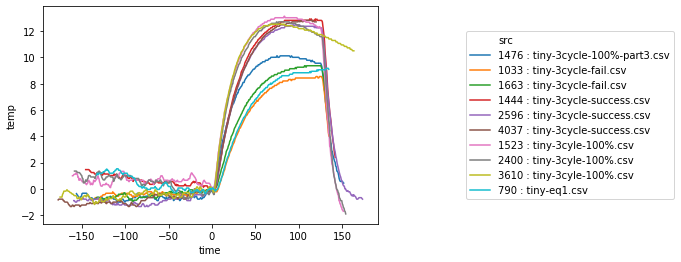

<Figure size 432x288 with 0 Axes>

In [10]:
allSpikes = getSpikesForAllRuns('eq_proof')
g = sns.lineplot(x='time', y='temp', hue='src', data=plotTempSpikes(allSpikes))
g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.show()

plt.savefig('cleanedData', dpi=1000)

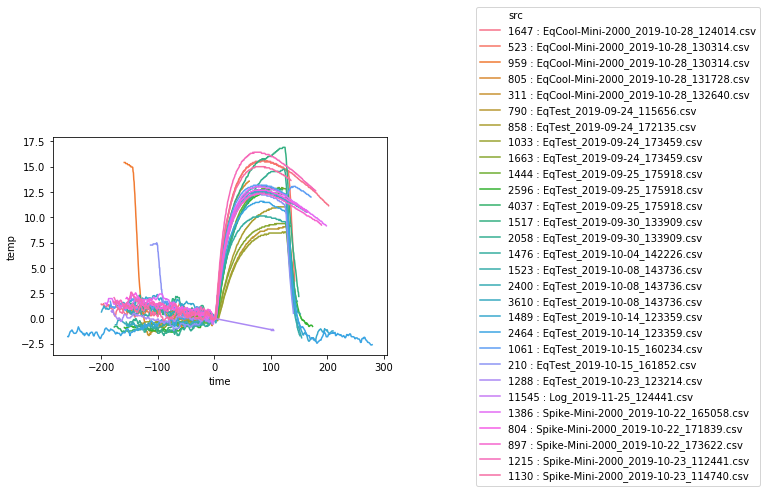

<Figure size 432x288 with 0 Axes>

In [11]:
allSpikes = getSpikesForAllRuns('data_and_control')
g = sns.lineplot(x='time', y='temp', hue='src', data=plotTempSpikes(allSpikes))
g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.show()

plt.savefig('allData', dpi=1000)

In [12]:
for spike in allSpikes:
    print(spike[fileKey], spike[origCutoffIndexKey])

EqCool-Mini-2000_2019-10-28_124014.csv 1647
EqCool-Mini-2000_2019-10-28_130314.csv 523
EqCool-Mini-2000_2019-10-28_130314.csv 959
EqCool-Mini-2000_2019-10-28_131728.csv 805
EqCool-Mini-2000_2019-10-28_132640.csv 311
EqTest_2019-09-24_115656.csv 790
EqTest_2019-09-24_172135.csv 858
EqTest_2019-09-24_173459.csv 1033
EqTest_2019-09-24_173459.csv 1663
EqTest_2019-09-25_175918.csv 1444
EqTest_2019-09-25_175918.csv 2596
EqTest_2019-09-25_175918.csv 4037
EqTest_2019-09-30_133909.csv 1517
EqTest_2019-09-30_133909.csv 2058
EqTest_2019-10-04_142226.csv 1476
EqTest_2019-10-08_143736.csv 1523
EqTest_2019-10-08_143736.csv 2400
EqTest_2019-10-08_143736.csv 3610
EqTest_2019-10-14_123359.csv 1489
EqTest_2019-10-14_123359.csv 2464
EqTest_2019-10-15_160234.csv 1061
EqTest_2019-10-15_161852.csv 210
EqTest_2019-10-23_123214.csv 1288
Log_2019-11-25_124441.csv 11545
Spike-Mini-2000_2019-10-22_165058.csv 1386
Spike-Mini-2000_2019-10-22_171839.csv 804
Spike-Mini-2000_2019-10-22_173622.csv 897
Spike-Mini-2000_

In [13]:
# Cutoff Temp
coTempKey = 'cutoff_temp'
# Spike Temp
spikeTempKey = 'spike_temp'
# Cutoff Power
coPowerKey = 'cutoff_power'
# Cutoff Current
coCurrentKey = 'cutoff_current'
# Cutoff Voltage
coVoltageKey = 'cutoff_voltage'
# Cutoff Ambient Temp
coAmbKey = 'cutoff_ambient_temp'
# Spike delta temp
tempDeltaKey = 'temp_delta'

for spike in allSpikes:
    cutoff_index = spike[coiKey]
    # print(cutoff_index, spike[samplesKey][cutoff_index].pwm, spike[samplesKey][cutoff_index+1].pwm)
    cutoffSample = spike[samplesKey][cutoff_index]
    spike[coTempKey] = float(cutoffSample.motorTemp)
    spike[spikeTempKey] = max(map(lambda sample: float(sample.motorTemp), spike[samplesKey]))
    spike[coPowerKey] = float(cutoffSample.power)
    spike[coCurrentKey] = float(cutoffSample.current)
    spike[coVoltageKey] = float(cutoffSample.voltage)
    spike[coAmbKey] = float(cutoffSample.ambTemp)
    spike[tempDeltaKey] = spike[spikeTempKey] - spike[coTempKey]

In [14]:
allSpikes

[{'samples': [< 910.0583752500008, 2000, 23.681850196499298, 44.60741108759649, 9394, 1056.3859432161673, 83.975, 98.886875, 74.8625 >,
   < 910.8556692500006, 2000, 23.679443820503234, 44.69634573989593, 9384, 1058.3845307680847, 83.975, 98.825, 74.8625 >,
   < 911.6742080000007, 2000, 23.672826157038184, 44.93821080828395, 9372, 1063.8143995759503, 83.975, 98.825, 74.75 >,
   < 912.4854567500009, 2000, 23.6750745035496, 44.82947009522553, 9376, 1061.3408017441209, 83.975, 98.825, 74.75 >,
   < 913.3017317500013, 2000, 23.675494250801734, 44.79146515194457, 9380, 1060.4599609211061, 83.975, 98.83625, 74.75 >,
   < 914.1124467500009, 2000, 23.67013879850454, 44.98650786315879, 9367, 1064.8368788346045, 83.975, 98.9375, 74.75 >,
   < 914.9255235000007, 2000, 23.67313452989016, 44.84263898245844, 9379, 1061.565668125949, 83.975, 98.79125, 74.75 >,
   < 915.7354920000013, 2000, 23.6777579324453, 44.67085636258629, 9385, 1057.7055231075994, 83.975, 98.7125, 74.766875 >,
   < 916.5609990000

In [15]:
import pandas as pd
srcDocKey = 'src_doc'

df = pd.DataFrame(allSpikes)
df[srcDocKey] = df[origCutoffIndexKey].map(str) + ' : ' + df[fileKey]
df = df.drop([samplesKey, origCutoffIndexKey, coiKey, fileKey, origCutoffIndexKey], axis=1)
df

,cutoff_temp,spike_temp,cutoff_power,cutoff_current,cutoff_voltage,cutoff_ambient_temp,temp_delta,src_doc
0,97.475000,113.11250,1054.473316,44.711948,23.583714,74.378750,15.637500,1647 : EqCool-Mini-2000_2019-10-28_124014.csv
1,97.199375,112.77500,1051.901981,44.838521,23.459787,74.637500,15.575625,523 : EqCool-Mini-2000_2019-10-28_130314.csv
2,96.800000,112.21250,1029.018743,43.957535,23.409384,74.525000,15.412500,959 : EqCool-Mini-2000_2019-10-28_130314.csv
3,96.395000,109.96250,972.192918,42.421809,22.917292,74.637500,13.567500,805 : EqCool-Mini-2000_2019-10-28_131728.csv
4,96.006875,98.93750,941.354248,41.603770,22.626663,74.862500,2.930625,311 : EqCool-Mini-2000_2019-10-28_132640.csv
5,77.500625,86.67500,533.064697,29.864544,17.849418,0.000000,9.174375,790 : EqTest_2019-09-24_115656.csv
6,83.412500,94.43750,697.497227,34.782437,20.053148,0.000000,11.025000,858 : EqTest_2019-09-24_172135.csv
7,82.400000,90.95000,530.320192,29.583525,17.926209,0.000000,8.550000,1033 : EqTest_2019-09-24_173459.csv
8,80.228750,89.60000,479.130905,27.821743,17.221456,0.000000,9.371250,1663 : EqTest_2019-09-24_173459.csv
9,83.525000,96.46250,756.169885,36.523324,20.703754,0.000000,12.937500,1444 : EqTest_2019-09-25_175918.csv


ValueError: `dataset` input should have multiple elements.

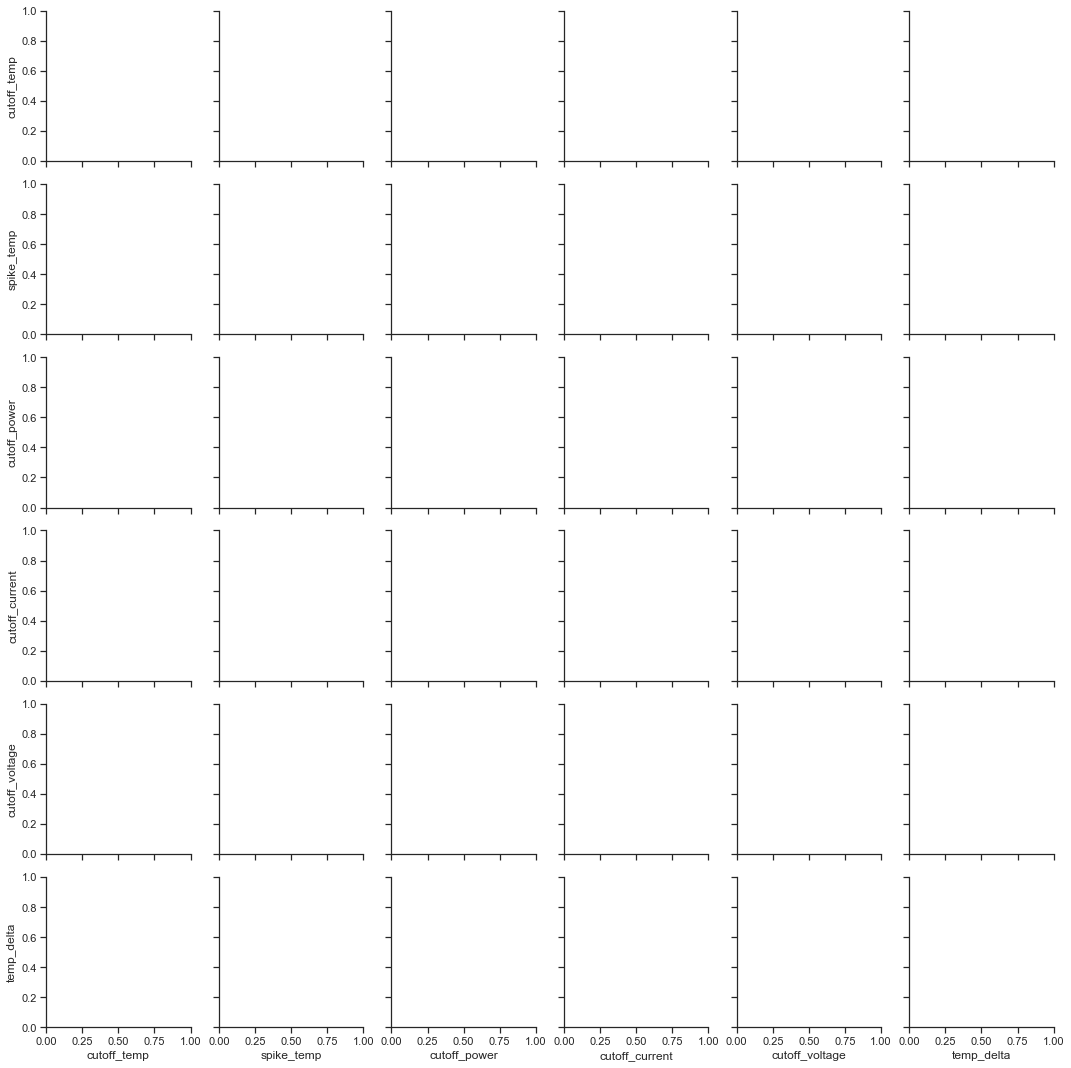

In [16]:
sns.set(style="ticks")
sns.pairplot(df.drop([coAmbKey], axis=1), hue=srcDocKey)

In [ ]:
# Ignore test runs without the ambient temp
sns.pairplot(df[df[coAmbKey] != 0], hue=srcDocKey)